# Introduction to image segmentation

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Dataset Generation
The code implements a synthetic dataset generator that creates circle images with noise.
1. **Input Generation**:
   - Creates random circles with varying positions and sizes
   - Adds Gaussian noise to create noisy input images
2. **Target Generation**:
   - Clean circle images without noise
   - Created using distance-based calculation

In [6]:
# Create a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a random input image
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 4)

        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target = (distance < radius).float().unsqueeze(0)

        # Add noise to the target to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.8
        input_image = target + noise

        return input_image, target

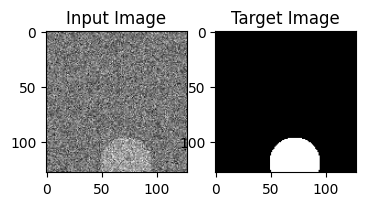

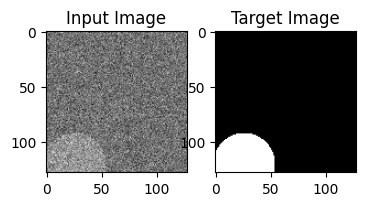

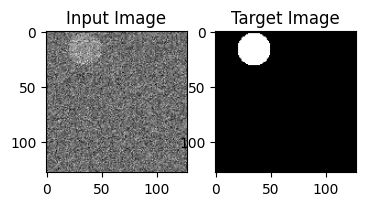

In [7]:
import matplotlib.pyplot as plt
# Create an instance of the dataset
dataset = SimpleDataset(size=1, image_size=128)

# Get a sample from the dataset
for i in range(3):
    input_image, target = dataset[i]
    # Visualize the input image
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0], cmap='gray')
    plt.title('Input Image')
    # plt.show()
    # Visualize the target image
    plt.subplot(1, 2, 2)
    plt.imshow(target[0], cmap='gray')
    plt.title('Target Image')
    plt.show()
    # break


# Model Architectures: Simple image to image

[Simple Autoencoder](https://blog.paperspace.com/convolutional-autoencoder/)

Features:
- Single downsample layer (Conv2d)
- Single upsample layer (ConvTranspose2d)
- Minimal architecture for demonstration

In [8]:
# Define a simple model with ConvTranspose2d
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer to reduce spatial dimensions
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        # ConvTranspose2d layer to increase spatial dimensions
        self.conv_transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Downsample
        x = self.conv(x)
        # Upsample
        x = self.conv_transpose(x)
        x=torch.sigmoid(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [10]:
# Training loop
def training_loop(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

In [11]:
# Initialize the model, loss function, and optimizer
model = SimpleAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.2855
Epoch [2/100], Average Loss: 0.2836
Epoch [3/100], Average Loss: 0.2809
Epoch [4/100], Average Loss: 0.2791
Epoch [5/100], Average Loss: 0.2761
Epoch [6/100], Average Loss: 0.2738
Epoch [7/100], Average Loss: 0.2712
Epoch [8/100], Average Loss: 0.2677
Epoch [9/100], Average Loss: 0.2641
Epoch [10/100], Average Loss: 0.2598
Epoch [11/100], Average Loss: 0.2552
Epoch [12/100], Average Loss: 0.2513
Epoch [13/100], Average Loss: 0.2463
Epoch [14/100], Average Loss: 0.2416
Epoch [15/100], Average Loss: 0.2369
Epoch [16/100], Average Loss: 0.2322
Epoch [17/100], Average Loss: 0.2267
Epoch [18/100], Average Loss: 0.2205
Epoch [19/100], Average Loss: 0.2166
Epoch [20/100], Average Loss: 0.2119
Epoch [21/100], Average Loss: 0.2074
Epoch [22/100], Average Loss: 0.2000
Epoch [23/100], Average Loss: 0.1974
Epoch [24/100], Average Loss: 0.1930
Epoch [25/100], Average Loss: 0.1868
Epoch [26/100], Average Loss: 0.1819
Epoch [27/100], Average Loss: 0.1761
Epoch [28/

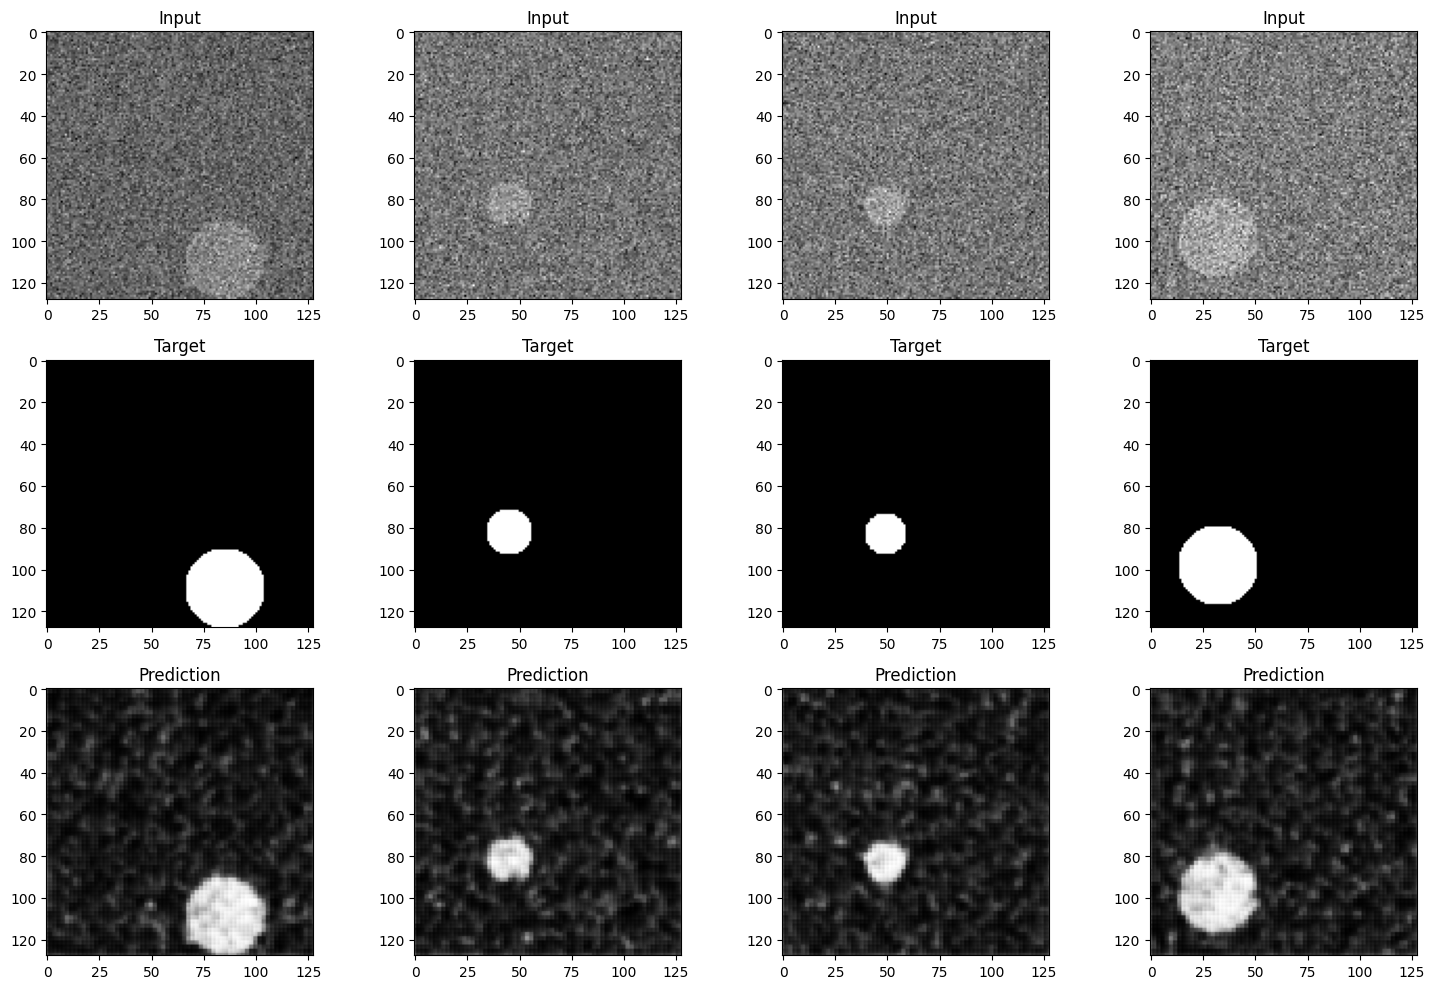

In [12]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

### Advanced Autoencoder
Architecture Details:
1. **Encoder**:
   - Progressive feature extraction
   - Increasing channel depth (1→16→32→64)
   - Decreasing spatial dimensions
   - ReLU activation for non-linearity

2. **Decoder**:
   - Mirror structure of encoder
   - Decreasing channel depth (64→32→16→1)
   - Increasing spatial dimensions
   - Sigmoid activation for final output

3. **Key Components**:
   - `output_padding=1`: Handles odd dimensions in upsampling
   - Symmetric channel progression
   - Skip connections not implemented (could be added for better results)


![picture](https://miro.medium.com/v2/resize:fit:640/format:webp/1*nqzWupxC60iAH2dYrFT78Q.png)

credit image: https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f

In [13]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.1522
Epoch [2/100], Average Loss: 0.0938
Epoch [3/100], Average Loss: 0.0828
Epoch [4/100], Average Loss: 0.0764
Epoch [5/100], Average Loss: 0.0711
Epoch [6/100], Average Loss: 0.0756
Epoch [7/100], Average Loss: 0.0663
Epoch [8/100], Average Loss: 0.0659
Epoch [9/100], Average Loss: 0.0578
Epoch [10/100], Average Loss: 0.0548
Epoch [11/100], Average Loss: 0.0325
Epoch [12/100], Average Loss: 0.0243
Epoch [13/100], Average Loss: 0.0214
Epoch [14/100], Average Loss: 0.0170
Epoch [15/100], Average Loss: 0.0118
Epoch [16/100], Average Loss: 0.0113
Epoch [17/100], Average Loss: 0.0103
Epoch [18/100], Average Loss: 0.0085
Epoch [19/100], Average Loss: 0.0072
Epoch [20/100], Average Loss: 0.0073
Epoch [21/100], Average Loss: 0.0060
Epoch [22/100], Average Loss: 0.0060
Epoch [23/100], Average Loss: 0.0050
Epoch [24/100], Average Loss: 0.0045
Epoch [25/100], Average Loss: 0.0047
Epoch [26/100], Average Loss: 0.0046
Epoch [27/100], Average Loss: 0.0041
Epoch [28/

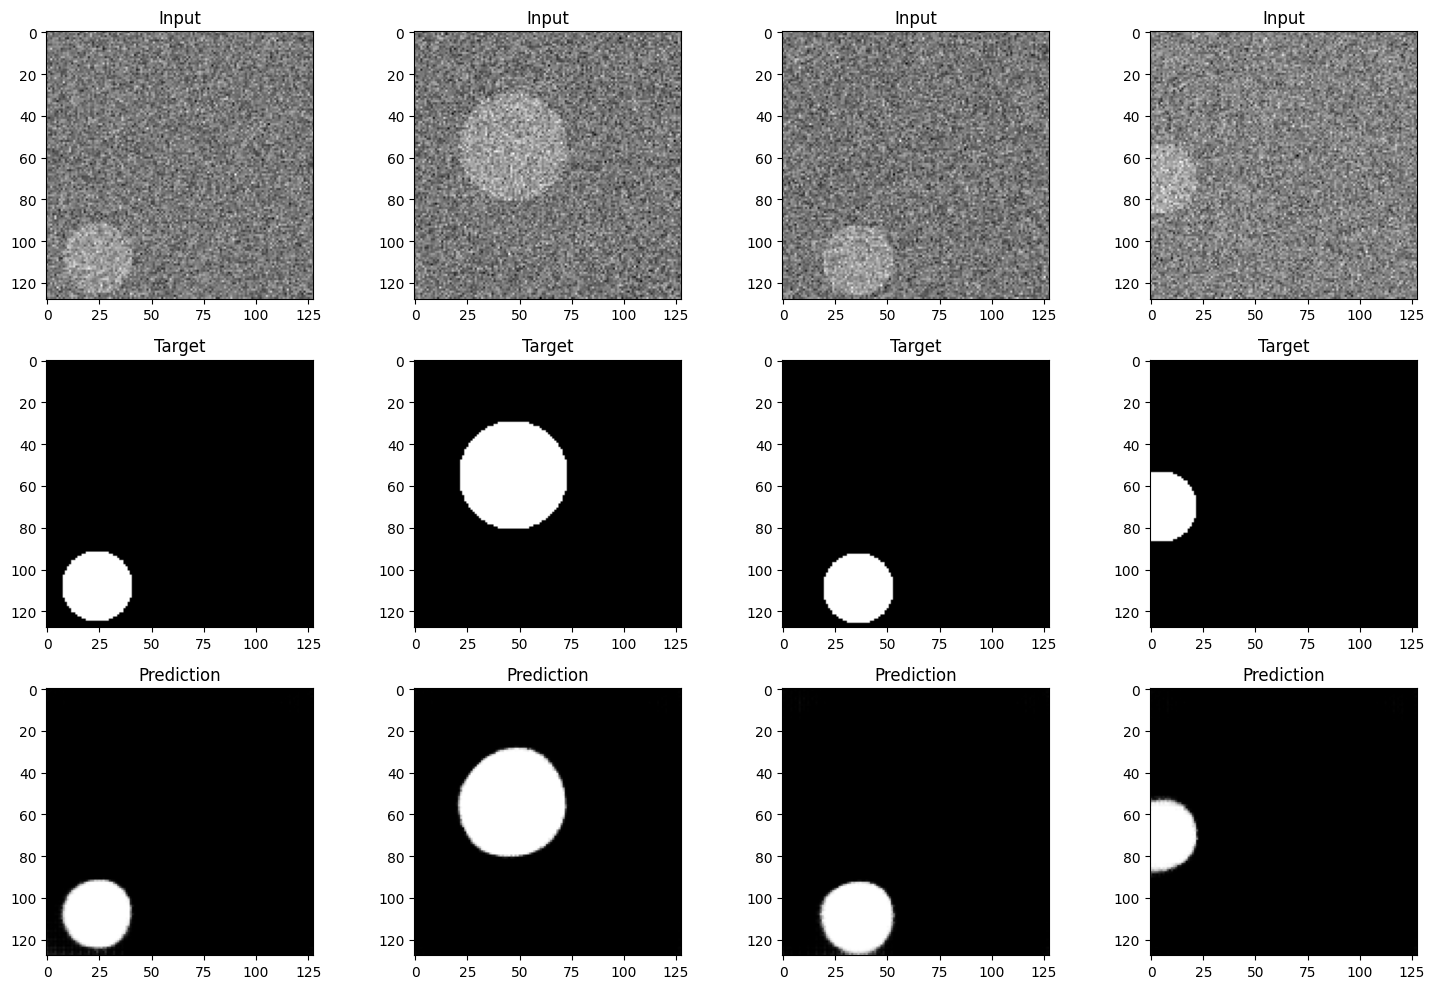

In [15]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

## Common Issues and Solutions

1. **Checkerboard Artifacts**:
   - Caused by transposed convolutions
   - Solution: Use resize-convolution instead

2. **Blurry Outputs**:
   - Common with MSE loss
   - Solution: Add perceptual or adversarial loss

3. **Training Stability**:
   - Monitor loss curves
   - Adjust learning rate if needed
   - Add gradient clipping if necessary

# U-Net architecture
[Pytorch-UNet](https://github.com/milesial/Pytorch-UNet)

U-Net is a convolutional neural network architecture designed for biomedical image segmentation. Its name comes from its U-shaped architecture, consisting of:
- Contracting path (encoder)
- Expanding path (decoder)
- Skip connections between corresponding encoder and decoder layers
### Data Flow:

1. **Encoder Path**:
   - Input → e1: 1→64 channels
   - e1 → e2: 64→128 channels
   - e2 → e3: 128→256 channels
   - e3 → e4: 256→512 channels

2. **Skip Connections**:
   - d1 + e3: 256 + 256 = 512 channels
   - d2 + e2: 128 + 128 = 256 channels
   - d3 + e1: 64 + 64 = 128 channels

3. **Decoder Path**:
   - e4 → d1: 512→256 channels
   - [d1,e3] → d2: 512→128 channels
   - [d2,e2] → d3: 256→64 channels
   - [d3,e1] → out: 128→1 channels

![picture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

credit image: https://arxiv.org/abs/1505.04597v1

In [16]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [17]:
model = UNet(in_channels=1, out_channels=1).to(device)
# criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 1.1538
Epoch [2/100], Average Loss: 0.4442
Epoch [3/100], Average Loss: 0.3639
Epoch [4/100], Average Loss: 0.1982
Epoch [5/100], Average Loss: 0.0807
Epoch [6/100], Average Loss: 0.1601
Epoch [7/100], Average Loss: 0.0846
Epoch [8/100], Average Loss: 0.0247
Epoch [9/100], Average Loss: 0.0090
Epoch [10/100], Average Loss: 0.0076
Epoch [11/100], Average Loss: 0.0076
Epoch [12/100], Average Loss: 0.0069
Epoch [13/100], Average Loss: 0.0070
Epoch [14/100], Average Loss: 0.0068
Epoch [15/100], Average Loss: 0.0067
Epoch [16/100], Average Loss: 0.0071
Epoch [17/100], Average Loss: 0.0074
Epoch [18/100], Average Loss: 0.0067
Epoch [19/100], Average Loss: 0.0064
Epoch [20/100], Average Loss: 0.0064
Epoch [21/100], Average Loss: 0.0066
Epoch [22/100], Average Loss: 0.0064
Epoch [23/100], Average Loss: 0.0064
Epoch [24/100], Average Loss: 0.0069
Epoch [25/100], Average Loss: 0.0065
Epoch [26/100], Average Loss: 0.0068
Epoch [27/100], Average Loss: 0.0065
Epoch [28/

In [18]:
# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

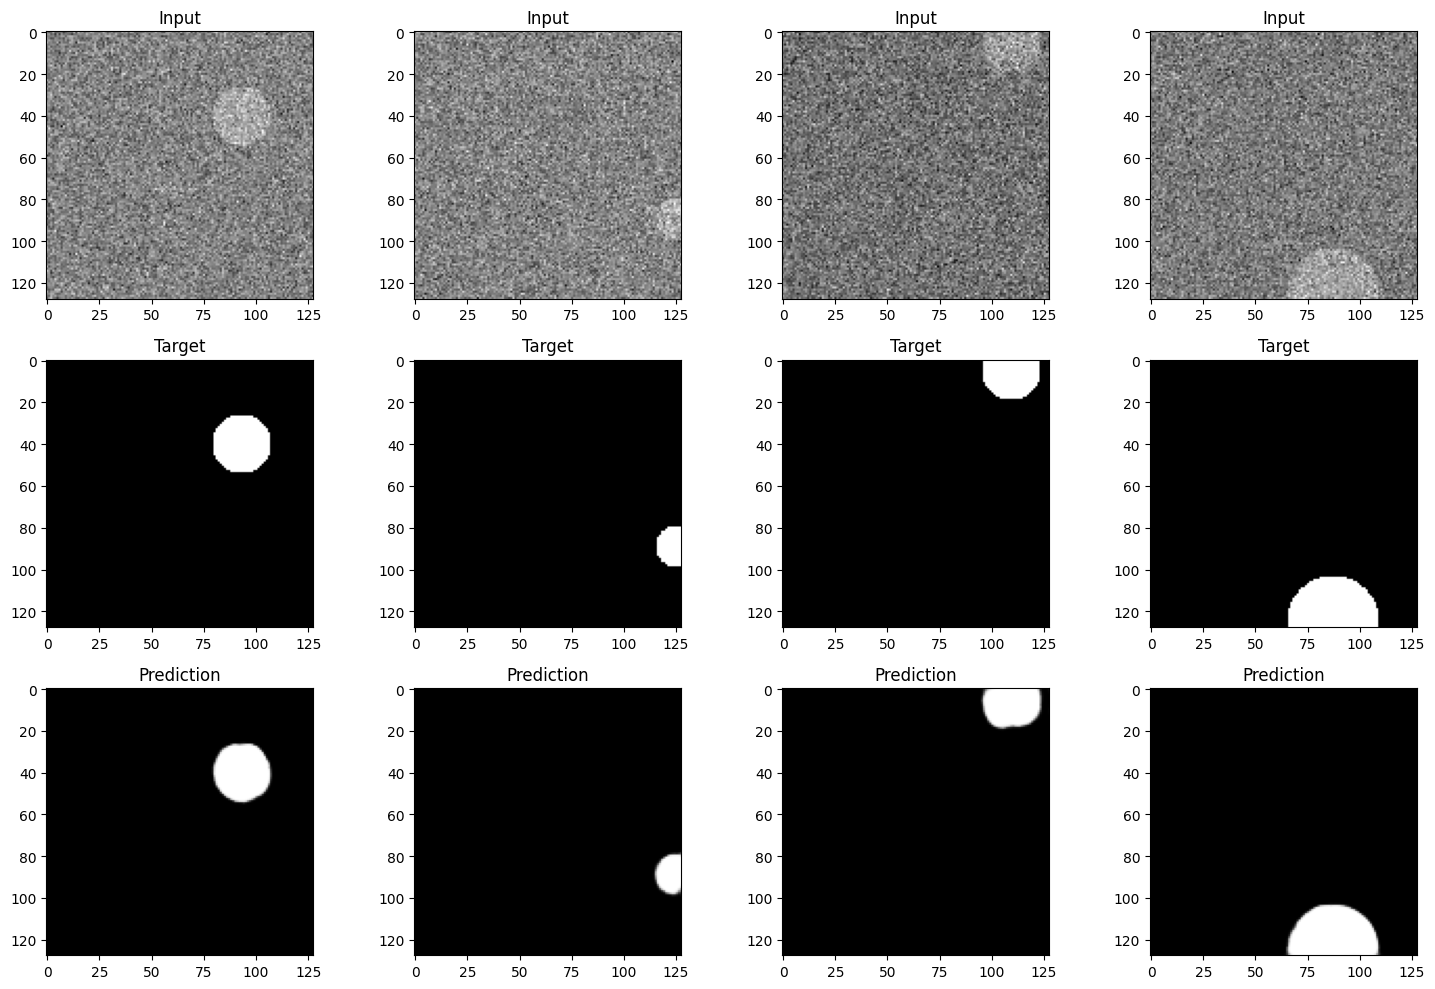

In [19]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

In [20]:
# !pip install torchviz

In [21]:
# # Visualize the model architecture
# from torchviz import make_dot

# x = torch.randn(1, 1, 128, 128).to(device)
# y = model(x)
# dot = make_dot(y.mean(), params=dict(model.named_parameters()))
# dot.render("unet_architecture", format="png")

# Multiple object
- Channel 0: Circle mask
- Channel 1: Rectangle mask

In [22]:
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a blank canvas for target
        target = torch.zeros(2, self.image_size, self.image_size)

        # Generate circle
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 6)
        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target[0] = (distance < radius).float()

        # Generate rectangle
        rect_x = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_y = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_w = np.random.randint(self.image_size // 8, self.image_size // 4)
        rect_h = np.random.randint(self.image_size // 8, self.image_size // 4)
        target[1, rect_x:rect_x+rect_w, rect_y:rect_y+rect_h] = 1

        # Combine circle and rectangle
        combined_target = (target.sum(dim=0) > 0).float().unsqueeze(0)

        # Add noise to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.5
        input_image = combined_target + noise

        return input_image, target

# U-Net Architecture for Multiple Objects
## Implementation Details
1. **Input Processing**:
   - Single channel noisy image
   - Size: 128x128x1

2. **Feature Extraction**:
   - Progressive downsampling
   - Increasing feature channels

3. **Decoding Process**:
   - Progressive upsampling
   - Skip connections
   - Final output: 2 channel masks

4. **Output Processing**:
   - Channel 0: Circle probability map
   - Channel 1: Rectangle probability map

In [23]:
# Define the U-Net architecture (unchanged)
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [24]:
# Create the dataset and data loader
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [25]:
model = UNet(in_channels=1, out_channels=2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 5
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/5], Average Loss: 0.7801
Epoch [2/5], Average Loss: 0.5332
Epoch [3/5], Average Loss: 0.4200
Epoch [4/5], Average Loss: 0.1879
Epoch [5/5], Average Loss: 0.1268


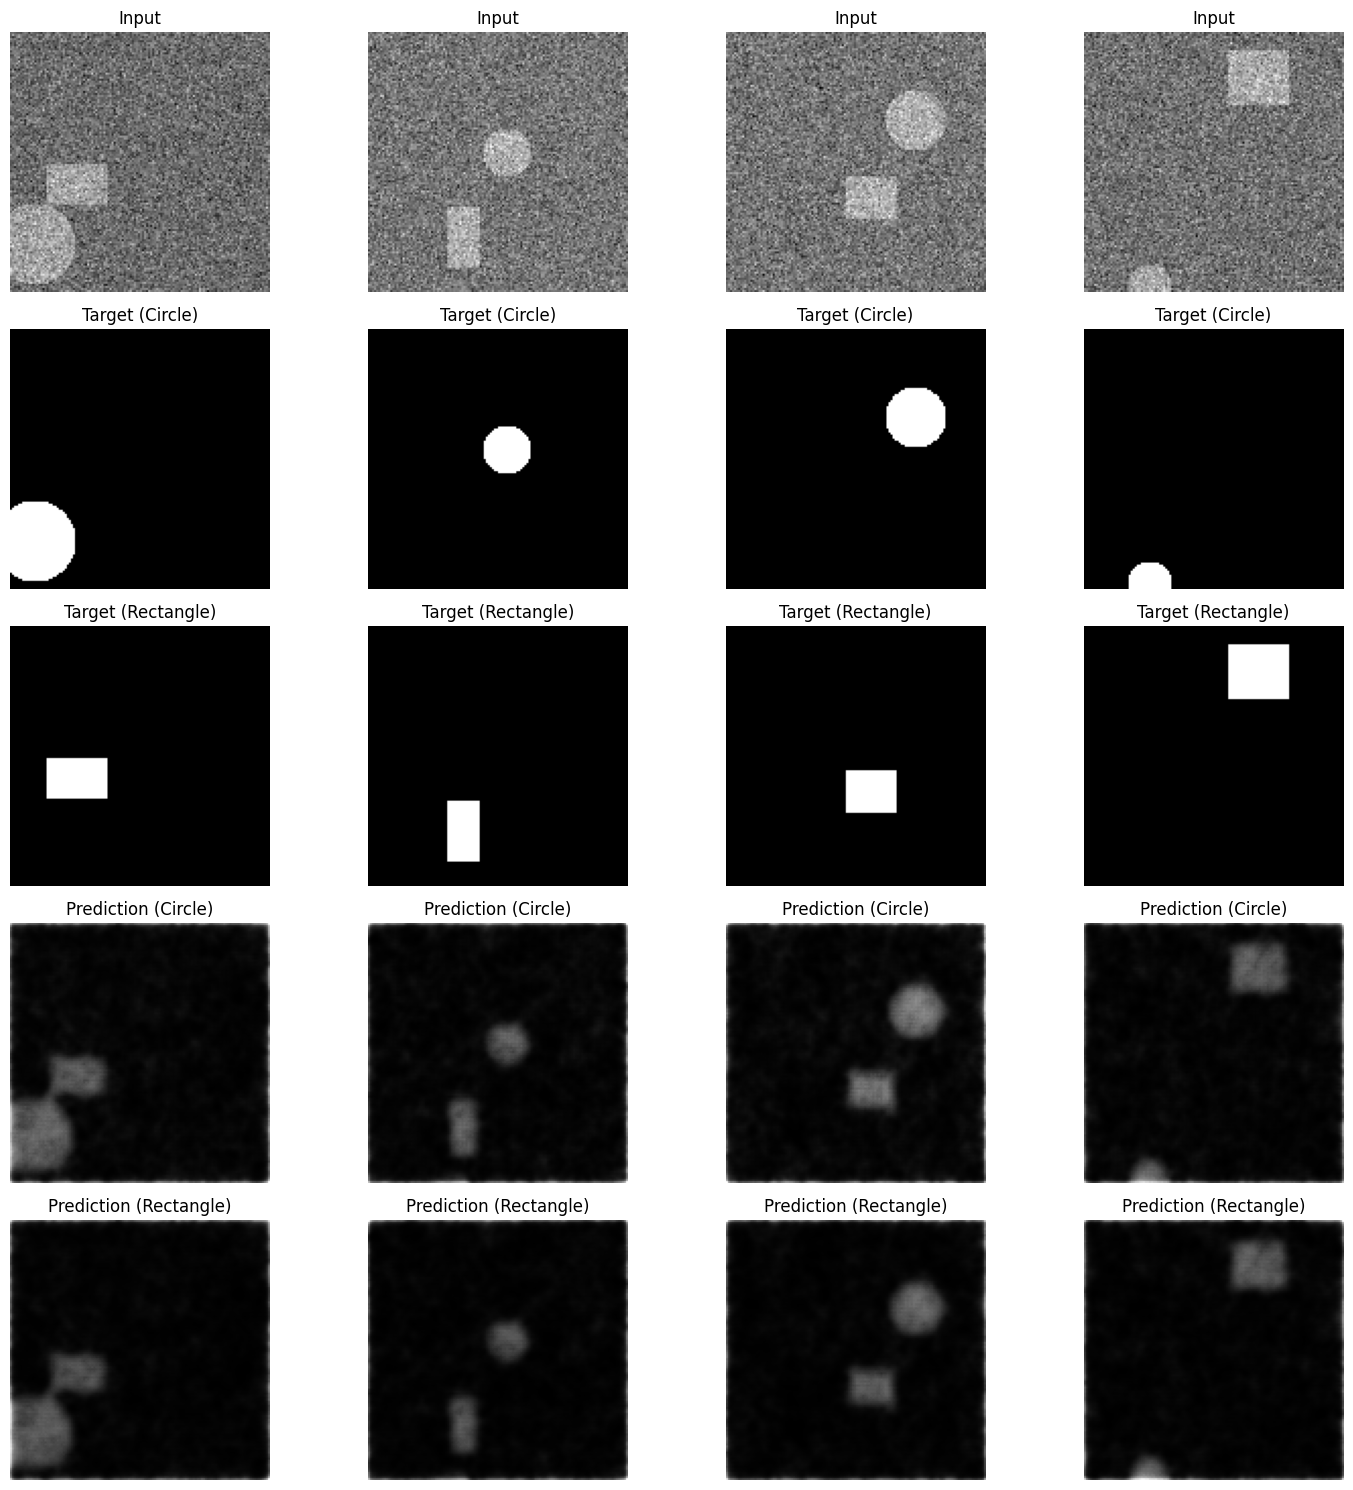

In [26]:
# Visualize results
# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(5, 4, figsize=(15, 15))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[0, i].axis('off')

        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target (Circle)')
        axes[1, i].axis('off')

        axes[2, i].imshow(targets[i, 1].cpu(), cmap='gray')
        axes[2, i].set_title('Target (Rectangle)')
        axes[2, i].axis('off')

        axes[3, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[3, i].set_title('Prediction (Circle)')
        axes[3, i].axis('off')

        axes[4, i].imshow(outputs[i, 1].cpu(), cmap='gray')
        axes[4, i].set_title('Prediction (Rectangle)')
        axes[4, i].axis('off')

    plt.tight_layout()
    plt.show()

# Hand on

Revise the code to be able to segment 4 objects per image using U-Net.

In [33]:
# from PIL import Image
import os

# Define the SimpleDataset with 4 objects
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128, save_path=None):
        self.size = size
        self.image_size = image_size
        self.save_path = save_path  # Path for saving input and target data

        # Create directories for saving data
        if save_path:
            os.makedirs(os.path.join(save_path, "input_images"), exist_ok=True)
            os.makedirs(os.path.join(save_path, "targets"), exist_ok=True)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        input_image = torch.rand(1, self.image_size, self.image_size) * 0.2  # Add noise
        target = torch.zeros(4, self.image_size, self.image_size)  # 4 channels for 4 objects

        # Generate the 4 objects: Circle, Rectangle, Pentagon, Oval
        shapes = ['circle', 'rectangle', 'pentagon', 'oval']
        for i, shape in enumerate(shapes):
            x, y = np.random.randint(20, self.image_size - 20, size=2)
            size = np.random.randint(10, 20)

            if shape == 'circle':
                xx, yy = np.meshgrid(np.arange(self.image_size), np.arange(self.image_size))
                mask = ((xx - x) ** 2 + (yy - y) ** 2) <= size**2
                target[i, mask] = 1
            elif shape == 'rectangle':
                x2, y2 = x + size, y + size
                target[i, y:y2, x:x2] = 1
            elif shape == 'pentagon':
                coords = np.array([
                    [x, y],
                    [x + size, y],
                    [x + int(size * 1.5), y + size],
                    [x + size // 2, y + int(size * 1.5)],
                    [x - size // 2, y + size]
                ])
                xx, yy = np.meshgrid(np.arange(self.image_size), np.arange(self.image_size))
                mask = np.zeros_like(target[i].cpu().numpy(), dtype=bool)
                mask = self.polygon_mask(coords, mask)
                target[i, mask] = 1
            elif shape == 'oval':
                xx, yy = np.meshgrid(np.arange(self.image_size), np.arange(self.image_size))
                mask = (((xx - x) / size) ** 2 + ((yy - y) / (size // 2)) ** 2) <= 1
                target[i, mask] = 1

        # Add object shapes to the input image
        input_image += target.sum(0) * 0.8
        input_image = torch.clip(input_image, 0, 1)  # Clip to valid range [0, 1]

        # Save the data if save_path is provided
        if self.save_path:
            self.save_data(input_image, target, idx)

        return input_image, target

    def polygon_mask(self, vertices, mask):
        from skimage.draw import polygon
        rr, cc = polygon(vertices[:, 1], vertices[:, 0], mask.shape)
        mask[rr, cc] = True
        return mask

    # Optional for saving image and target
    def save_data(self, input_image, target, idx):
        input_image_path = os.path.join(self.save_path, "input_images", f"input_{idx:04d}.png")
        target_path = os.path.join(self.save_path, "targets", f"target_{idx:04d}.npy")

        # Save input image as .png
        input_image_np = (input_image[0].cpu().numpy() * 255).astype(np.uint8)
        Image.fromarray(input_image_np).save(input_image_path)

        # Save target as .npy
        target_np = target.cpu().numpy()
        np.save(target_path, target_np)

In [34]:
# Define the U-Net architecture, code here
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [35]:
# Training setup, code here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = SimpleDataset(size=500)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = UNet(in_channels=1, out_channels=4).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [46]:
# Training loop, code here
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.0982
Epoch 2/30, Loss: 0.0875
Epoch 3/30, Loss: 0.1010
Epoch 4/30, Loss: 0.0851
Epoch 5/30, Loss: 0.0925
Epoch 6/30, Loss: 0.0837
Epoch 7/30, Loss: 0.0748
Epoch 8/30, Loss: 0.0932
Epoch 9/30, Loss: 0.0912
Epoch 10/30, Loss: 0.0846
Epoch 11/30, Loss: 0.0827
Epoch 12/30, Loss: 0.0698
Epoch 13/30, Loss: 0.0836
Epoch 14/30, Loss: 0.0761
Epoch 15/30, Loss: 0.0641
Epoch 16/30, Loss: 0.0653
Epoch 17/30, Loss: 0.0716
Epoch 18/30, Loss: 0.0717
Epoch 19/30, Loss: 0.0705
Epoch 20/30, Loss: 0.0521
Epoch 21/30, Loss: 0.0741
Epoch 22/30, Loss: 0.0608
Epoch 23/30, Loss: 0.0599
Epoch 24/30, Loss: 0.0539
Epoch 25/30, Loss: 0.0537
Epoch 26/30, Loss: 0.0544
Epoch 27/30, Loss: 0.0696
Epoch 28/30, Loss: 0.0451
Epoch 29/30, Loss: 0.0616
Epoch 30/30, Loss: 0.0485


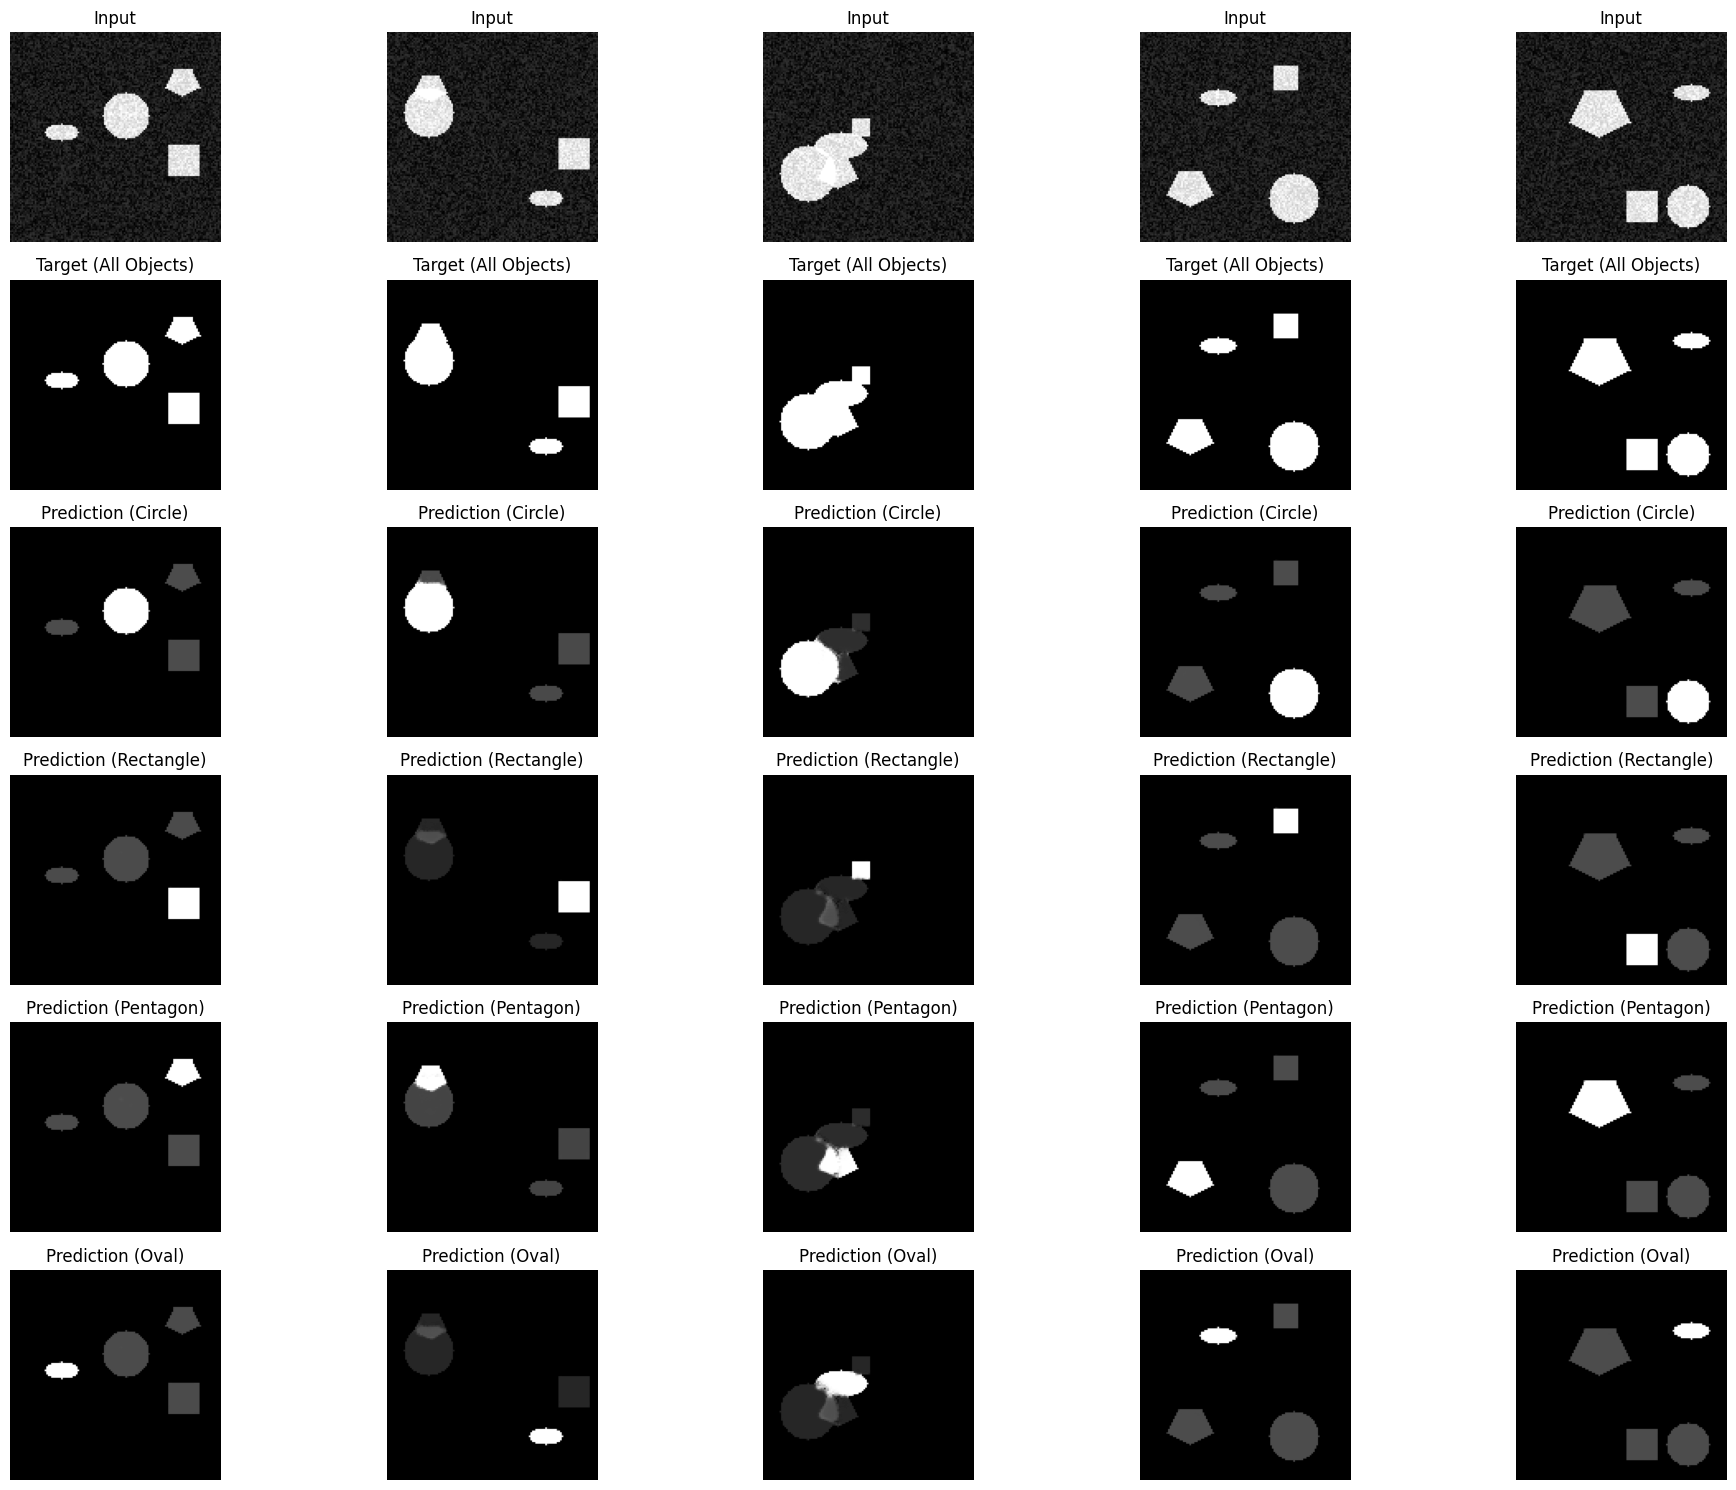

In [47]:
# Updated visualization with faded secondary objects in predictions
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = torch.sigmoid(model(inputs))

    fig, axes = plt.subplots(6, 5, figsize=(20, 15))  # 1 row for inputs, 1 for targets, 4 for predictions

    object_names = ["Circle", "Rectangle", "Pentagon", "Oval"]
    secondary_opacity = 0.3  # Opacity for secondary objects

    # Display inputs
    for i in range(5):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[0, i].axis('off')

    # Display targets (all objects combined)
    for i in range(5):
        combined_target = targets[i].sum(dim=0).cpu()  # Combine all object masks
        combined_target = torch.clamp(combined_target, 0, 1)  # Ensure values are in range [0, 1]
        axes[1, i].imshow(combined_target, cmap='gray')
        axes[1, i].set_title('Target (All Objects)')
        axes[1, i].axis('off')

    # Display predictions, split into rows for each object type
    for j in range(4):  # For each object
        for i in range(5):  # For each image
            main_object = outputs[i, j].cpu().numpy()
            other_objects = torch.sum(outputs[i].cpu(), dim=0).numpy() - main_object

            # Normalize and blend the images
            main_object_normalized = main_object / main_object.max() if main_object.max() > 0 else main_object
            other_objects_normalized = other_objects / other_objects.max() if other_objects.max() > 0 else other_objects

            blended_image = main_object_normalized + (secondary_opacity * other_objects_normalized)
            blended_image = np.clip(blended_image, 0, 1)  # Ensure values are in range [0, 1]

            # Display the blended image
            axes[j + 2, i].imshow(blended_image, cmap='gray')
            axes[j + 2, i].set_title(f'Prediction ({object_names[j]})')
            axes[j + 2, i].axis('off')

    plt.tight_layout()
    plt.show()



# High performance and well known model
https://pytorch.org/vision/stable/models.html

https://universe.roboflow.com/
